# Biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta, date
from itertools import product
from functools import reduce


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## tirar os warnings nao eh uma boa pratica, mas como os avisos ja foram mapeados
## optou-se por retira-los pra manter o codigo mais limpo e coeso
import warnings 
warnings.filterwarnings("ignore")

# Acessando arquivos


In [2]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [3]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/matriz_junho_mapeada.xlsx', index_col='Unnamed: 0')

#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

# Volumes por OD

## Organizacao dos volumes por OD da serie temporal

- muitas ODs nao tem viagens de todos pra todos os 18 pontos (ou seja, nem todo dia tem viagem de 18 x 18)

- os dados serao organizados de forma que todos os pares ODs estejam com todos os dias e volumes da serie historica no seguinte formato:

| PAR OD 	| DATA  	| VOLUME OD 	|
|--------	|-------	|-----------	|
| 1_1    	| 01/06 	| 2         	|
| 1_1    	| 02/06 	| 0         	|
| .      	| .     	| .         	|
| 15_20  	| 16/07 	| 1         	|
| .      	| .     	| .         	|
| 33_33  	| 30/08 	| 1         	|
| 33_33  	| 31/08 	| 4         	|

- O desenvolvimentoa baixo agrupa as viagens pelos seus dias e pelos pontos de partida e chegada das viagens
- Em seguida os dados sao pivotados para o formato de tabelas ODs diárias
- Por fim os dados sao reorganizados no formato descrito acima

In [4]:
viagens_validas

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),PontoInicial,...,longitudeI,dist_PontoI,PontoFinal,Nome_PontoF,latitudeF,longitudeF,dist_PontoF,NEW_PontoInicial,NEW_PontoFinal,day_of_week
0,None_6,1,0,Manha,2021-06-01 06:44:02,2021-06-01 06:45:20,1,333.068136,78.0,33,...,-47.061214,0.001096,29,Escola Sérgio P. Porto (PONTO INICIAL),-22.829490,-47.060281,0.000124,33,33,1
1,None_6,1,0,Manha,2021-06-01 07:58:17,2021-06-01 07:59:35,4,362.164440,78.0,34,...,-47.061207,0.001011,29,Escola Sérgio P. Porto (PONTO FINAL),-22.829638,-47.060359,0.000179,33,33,1
2,None_6,1,0,Manha,2021-06-01 09:06:10,2021-06-01 09:07:28,6,350.063969,78.0,33,...,-47.061166,0.000957,29,Escola Sérgio P. Porto (PONTO INICIAL),-22.829648,-47.060414,0.000180,33,33,1
3,None_6,1,0,Manha,2021-06-01 11:10:03,2021-06-01 11:11:21,7,361.522224,78.0,34,...,-47.061240,0.001020,29,Escola Sérgio P. Porto (PONTO FINAL),-22.829614,-47.060350,0.000153,33,33,1
4,None_6,1,0,Manha,2021-06-01 11:57:21,2021-06-01 11:58:42,9,339.187065,81.0,33,...,-47.061172,0.000860,29,Escola Sérgio P. Porto (PONTO INICIAL),-22.829681,-47.060513,0.000156,33,33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,None_8,31,92524,Manha,2021-08-31 12:57:57,2021-08-31 12:59:37,1,527.011253,100.0,13,...,-47.064937,0.000081,11,CECOM,-22.825647,-47.066167,0.001011,13,10,1
14484,None_8,31,93049,Tarde,2021-08-31 15:31:56,2021-08-31 15:33:16,1,825.952595,80.0,25,...,-47.067667,0.001754,13,Sobrapar,-22.831246,-47.063677,0.001125,17,13,1
14485,None_8,31,93049,Tarde,2021-08-31 15:31:56,2021-08-31 15:33:16,2,825.952595,80.0,25,...,-47.067667,0.001754,13,Sobrapar,-22.831246,-47.063677,0.001125,17,13,1
14486,None_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,13,...,-47.063912,0.000265,10,CECOM,-22.824985,-47.065243,0.001511,13,10,1


### Dados totais

In [5]:
vol_semanal = viagens_validas.groupby([ pd.Grouper(freq='1D',key = 'dataInicio')]).agg({'sequence':'count'}).reset_index()

vol_semanal.columns = [	'Data',	'Volume']
vol_semanal = vol_semanal.loc[(vol_semanal['Volume'] != 0) &  (vol_semanal['Volume'] != 1)].reset_index(drop=True)

vol_semanal

,Data,Volume
0,2021-06-01,139
1,2021-06-02,290
2,2021-06-07,241
3,2021-06-08,311
4,2021-06-09,291
...,...,...
58,2021-08-25,244
59,2021-08-26,290
60,2021-08-27,279
61,2021-08-30,221


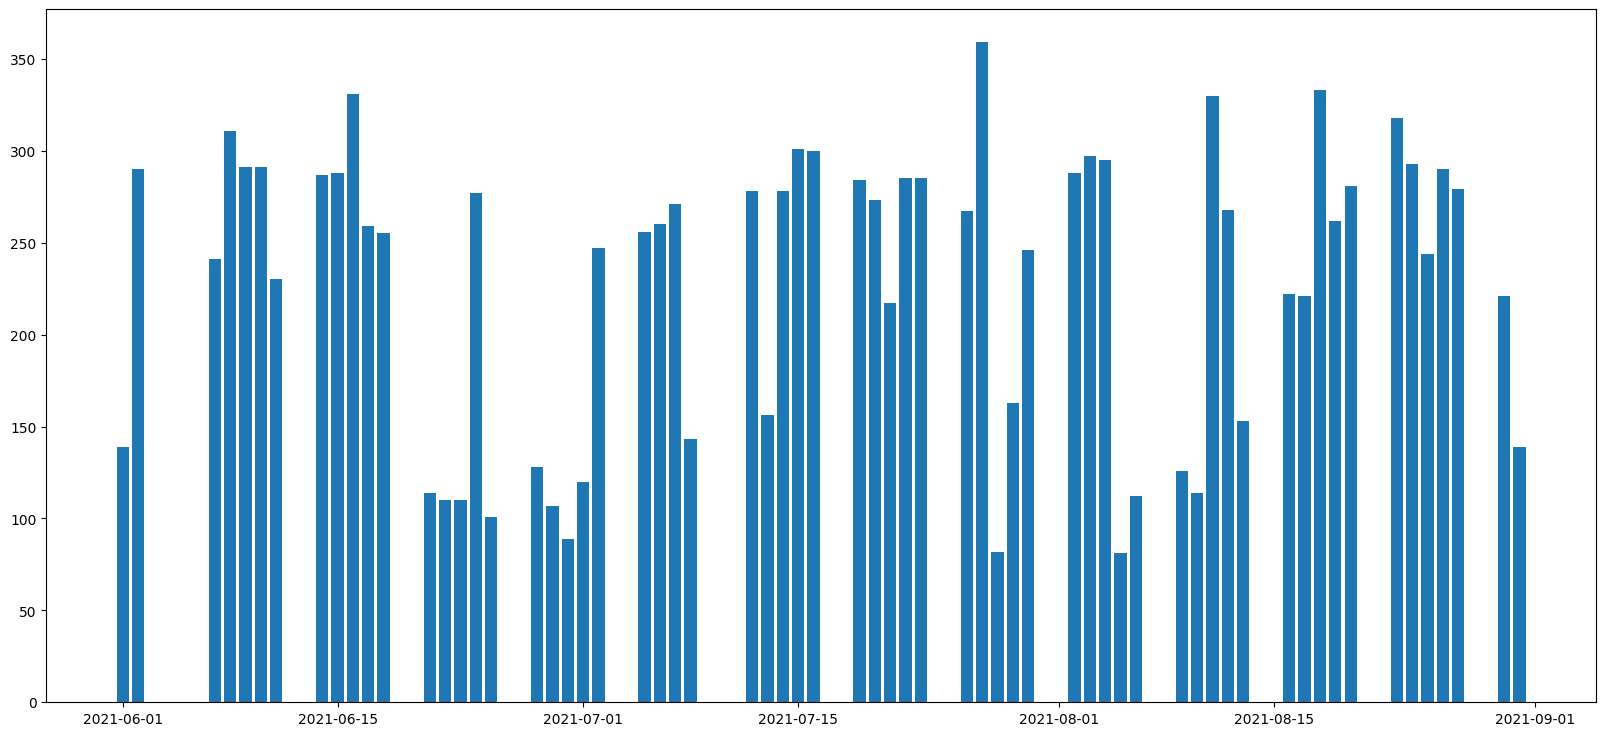

In [6]:
plt.rcParams["figure.figsize"] = (20,9)
plt.bar(vol_semanal.Data, vol_semanal.Volume)
plt.show()

In [7]:
agrupamento = viagens_validas.groupby([pd.Grouper(freq='1D',key = 'dataInicio'),'NEW_PontoInicial','NEW_PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento.columns = ['Data',	'PontoInicial',	'PontoFinal',	'Volume']
agrupamento


,Data,PontoInicial,PontoFinal,Volume
0,2021-06-01,1,6,2
1,2021-06-01,1,10,2
2,2021-06-01,1,17,3
3,2021-06-01,1,20,3
4,2021-06-01,1,23,4
...,...,...,...,...
5110,2021-08-31,32,31,1
5111,2021-08-31,33,13,1
5112,2021-08-31,33,15,1
5113,2021-08-31,33,17,3


### Validacao dos dados totais agora em matrizes OD

In [8]:
data__ = datetime(2021,6,1)

for day in range(10):

    print('===============',data__,'===============')
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).sum().sum())
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).shape)

    data__ = data__ + timedelta(days=1)

=============== 2021-06-01 00:00:00 ===============
139.0
(16, 16)
=============== 2021-06-02 00:00:00 ===============
290.0
(17, 17)
=============== 2021-06-03 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-04 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-05 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-06 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-07 00:00:00 ===============
241.0
(17, 17)
=============== 2021-06-08 00:00:00 ===============
311.0
(17, 17)
=============== 2021-06-09 00:00:00 ===============
291.0
(17, 17)
=============== 2021-06-10 00:00:00 ===============
291.0
(17, 17)


In [9]:

##########      GERA ODs DE TODOS OS DIAS DA ANALISE    #####################################

start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 8, 31) , timedelta(days=1)

ODs_diarios = []
# Gerando as ODs de cada dia
while (start_date <= end_date):

    ODs_diarios.append(agrupamento.loc[agrupamento['Data'] == start_date].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0))
    # print(start_date, end="\n")
    start_date += delta

print('ODS antes ---------------------------------------------------------------------------------------------------')
display(ODs_diarios[0])

########        CRIA UM DF_AUX COM TODAS AS LINHAS E COLUNAS E POPULA COM OS DADOS DA ODS  #####################################

pontos_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

for df in range(len(ODs_diarios)):
    df_aux = pd.DataFrame(columns = pontos_18, index=pontos_18)
    for col in pontos_18:
        try:
            df_aux.loc[:,col] = ODs_diarios[df][col]
        except:
            pass

    ODs_diarios[df] = df_aux.fillna(0).copy()

for day in range(92):
    ODs_diarios[day] = ODs_diarios[day].astype(int)
    
print('ODS dps ---------------------------------------------------------------------------------------------------')
display(ODs_diarios[0])



ODS antes ---------------------------------------------------------------------------------------------------


PontoFinal,1,5,6,9,10,13,15,17,18,20,21,22,23,31,32,33
PontoInicial,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0
5,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0
9,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
10,0.0,1.0,0.0,1.0,1.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0
13,1.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ODS dps ---------------------------------------------------------------------------------------------------


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,0,2,0,0,2,0,0,3,0,3,0,0,4,0,0,0,0
5,0,2,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0
6,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,4,2,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0
10,0,1,0,0,1,1,1,0,7,0,0,1,0,0,0,0,2,2
13,1,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0
15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,1
18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
## aqui garante que todos os DF tem 18x18

data__ = datetime(2021,6,1)

for day in range(3):

    print('=============================',data__,'=============================')
    print('soma da matriz \t',ODs_diarios[day].sum().sum())
    print('shape da matriz\t',ODs_diarios[day].shape)
    display(ODs_diarios[day])

    data__ = data__ + timedelta(days=1)

============================= 2021-06-01 00:00:00 =============================
soma da matriz 	 139
shape da matriz	 (18, 18)


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,0,2,0,0,2,0,0,3,0,3,0,0,4,0,0,0,0
5,0,2,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0
6,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,4,2,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0
10,0,1,0,0,1,1,1,0,7,0,0,1,0,0,0,0,2,2
13,1,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0
15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,1
18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


============================= 2021-06-02 00:00:00 =============================
soma da matriz 	 290
shape da matriz	 (18, 18)


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,3,0,0,0,4,0,0,4,1,3,0,2,4,0,0,2,0
5,1,3,0,0,1,1,0,0,1,0,0,2,7,0,0,3,0,0
6,2,1,0,0,1,3,0,0,3,0,0,0,1,0,0,0,1,0
8,5,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
9,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0
10,1,2,3,2,0,2,6,0,10,5,1,0,0,0,0,1,11,14
13,0,1,0,0,0,5,0,0,2,0,0,0,0,0,0,0,3,7
15,0,1,1,0,3,1,0,0,0,0,0,0,0,0,0,2,0,0
17,1,3,0,1,0,20,7,0,5,1,0,0,0,1,0,0,3,5
18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


============================= 2021-06-03 00:00:00 =============================
soma da matriz 	 0
shape da matriz	 (18, 18)


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
combinacoes_OD = []

for prod in product(pontos_18,pontos_18):
    combinacoes_OD.append(str(prod[0])+'_'+str(prod[1]))

random.sample(combinacoes_OD,5)

['6_23', '13_23', '9_15', '13_17', '32_17']

### Organizacao ds dados em series temporais para cada par OD

In [12]:
pontos_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]
# combinacoes_OD
start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 9, 1) , timedelta(days=1)

series_ods = pd.DataFrame(columns = ['OD', 'Data', 'Volume_OD'])

index_comb = 0

for row in pontos_18:
    for col in pontos_18:

        days = 0
        start_date = datetime(2021, 6, 1) 

        while start_date < end_date:
        
            # print(days,'\t',{'OD':combinacoes_OD[index_comb], 'Data':start_date, 'loc[row, col]' : '({},{})'.format(row, col),'Volume_OD':ODs_diarios[days].loc[row, col]})
        
            series_ods = pd.concat([series_ods,
                                        pd.DataFrame({'OD':combinacoes_OD[index_comb], 'Data':start_date, 'Volume_OD':ODs_diarios[days].loc[row,col]}, index=[0])
                                        ], axis = 0, ignore_index=True)
            start_date += timedelta(days=1)
            days += 1

        index_comb += 1
series_ods

,OD,Data,Volume_OD
0,1_1,2021-06-01,0
1,1_1,2021-06-02,0
2,1_1,2021-06-03,0
3,1_1,2021-06-04,0
4,1_1,2021-06-05,0
...,...,...,...
29803,33_33,2021-08-27,27
29804,33_33,2021-08-28,0
29805,33_33,2021-08-29,0
29806,33_33,2021-08-30,25


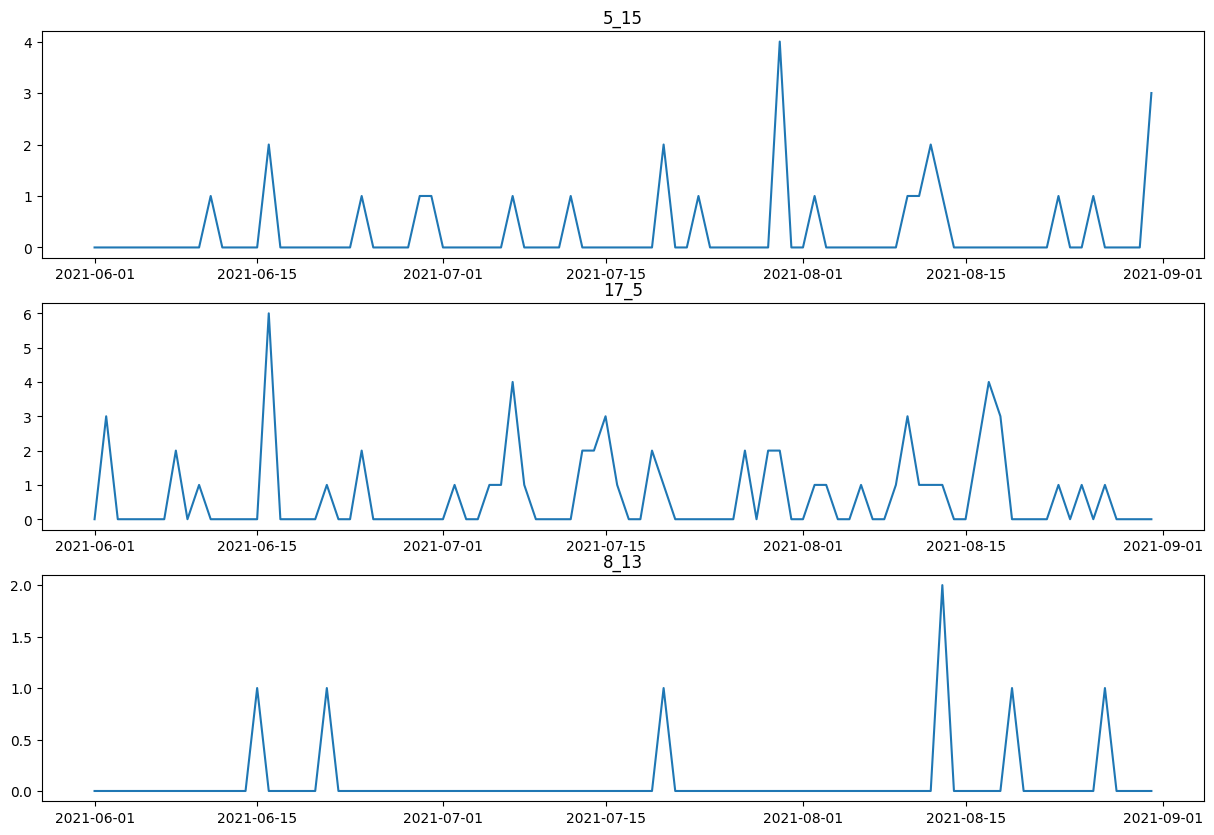

In [13]:
#### amostra de PAR OD para alguns pares

# amostra = random.sample(combinacoes_OD,3)
amostra = ['5_15', '17_5', '8_13']
fig, ax = plt.subplots(nrows=3, figsize = (15,10))

for _ in range(len(amostra)):
    ax[_].plot(series_ods.loc[series_ods["OD"]==amostra[_],'Data'], series_ods.loc[series_ods["OD"]==amostra[_],'Volume_OD'])
    ax[_].set_title(amostra[_])

# Modelagem

**Pontos importantes a serem considerados:**

* os parâmetros dos modelos serão os mesmos dos modelos dos volumes totais (serie historia de todos os dias, mais simples e sem diferenciacoes). Exemplo: Media móvel com 13 dias anteriores ou ARIMA com parametros (p,d,q) = (1,1,2)
* os erros calculados, que balizarão a escolha do melhor modelo, serão erros médios usando RMSE ou MAE para cada um dos 324 ODs, ou seja, média dos 324 erros
* nessa granularidade da análise a validacao visual dos modelos perde o sentido se tornando um componente de análise mais confuso
* Devido a alta granularidade poucos sao as series que tem muitos valores diferentes de zero, de forma que os dados serao arredondados para o inteiro mais proximo

## Media Movel

In [14]:
series_ods

,OD,Data,Volume_OD
0,1_1,2021-06-01,0
1,1_1,2021-06-02,0
2,1_1,2021-06-03,0
3,1_1,2021-06-04,0
4,1_1,2021-06-05,0
...,...,...,...
29803,33_33,2021-08-27,27
29804,33_33,2021-08-28,0
29805,33_33,2021-08-29,0
29806,33_33,2021-08-30,25


In [15]:
combinacoes_OD[:5]

['1_1', '1_5', '1_6', '1_8', '1_9']

#### Media Movel com step-by-step

In [16]:
### modela com step by step e calcula erro

In [17]:
for par in combinacoes_OD:
    par_od = series_ods.loc[series_ods["OD"] == par ]
    

In [19]:
series_ods

,OD,Data,Volume_OD
0,1_1,2021-06-01,0
1,1_1,2021-06-02,0
2,1_1,2021-06-03,0
3,1_1,2021-06-04,0
4,1_1,2021-06-05,0
...,...,...,...
29803,33_33,2021-08-27,27
29804,33_33,2021-08-28,0
29805,33_33,2021-08-29,0
29806,33_33,2021-08-30,25


In [20]:
series_ods_MA4 = series_ods.copy()

results_MA4 = list()
errors_324 = pd.DataFrame()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_MA4.loc[series_ods_MA4["OD"] == par ]
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            MA_base = X['Volume_OD'].rolling(4).mean().fillna(0)
            [temp.append(int(np.around(MA_base.values[i],0))) for i in range(len(MA_base))]
        else:
            MA_base = X['Volume_OD'].rolling(4).mean()
            temp.append(int(np.around(MA_base.values[-1],0)))

    ################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_MA4.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['MA4_RMSE'] = errors_RMSE
errors_324['MA4_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_MA4 = pd.concat([series_ods_MA4,pd.Series(reduce(lambda xs, ys: xs + ys, results_MA4), name = 'MA4_pred')], axis = 1, ignore_index = True)
series_ods_MA4.columns = ['OD', 'Data', 'Volume_OD', 'MA4_pred']

series_ods_MA4

,OD,Data,Volume_OD,MA4_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,24
29804,33_33,2021-08-28,0,19
29805,33_33,2021-08-29,0,14
29806,33_33,2021-08-30,25,13


In [21]:
errors_324

,OD,MA4_RMSE,MA4_MAE
0,1_1,0.208514,0.043478
1,1_5,1.507229,1.141304
2,1_6,1.179536,0.869565
3,1_8,0.000000,0.000000
4,1_9,0.989071,0.652174
...,...,...,...
319,33_23,0.208514,0.043478
320,33_26,0.000000,0.000000
321,33_31,0.714751,0.402174
322,33_32,0.820922,0.456522


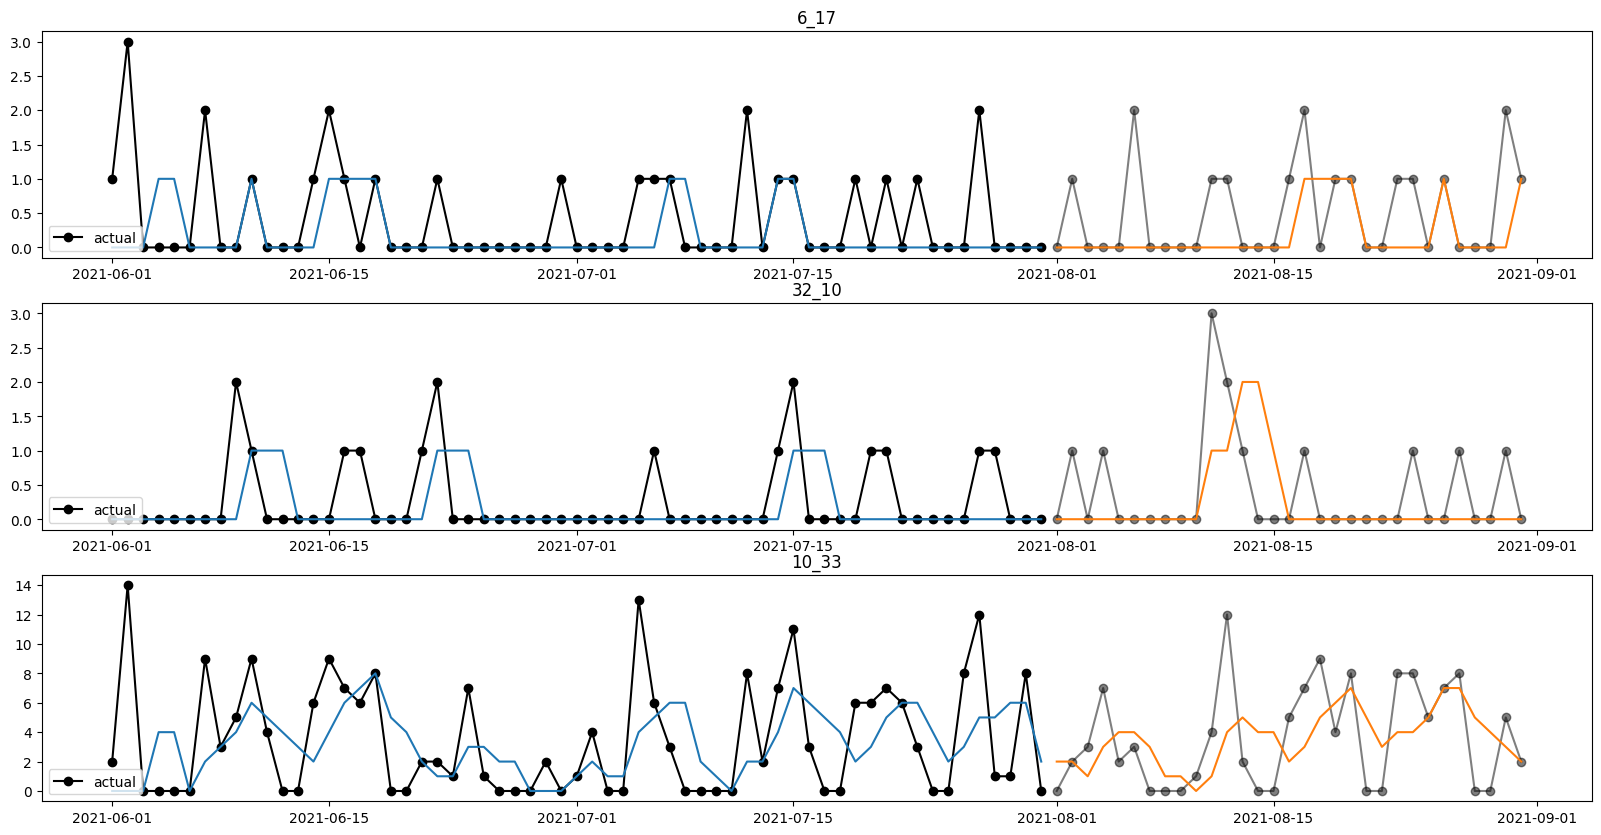

In [23]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][:61], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][61:], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][:61], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'MA4_pred'][:61], )
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][61:], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'MA4_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Suavizacao Exponencial


In [24]:
series_ods_SES = series_ods.copy()

results_SES = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_SES.loc[series_ods_SES["OD"] == par ].reset_index(drop=True)
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            SES_base = SimpleExpSmoothing(X['Volume_OD'].values, initialization_method="estimated").fit()
            [temp.append(int(np.around(SES_base.fittedvalues[i],0))) for i in range(len(SES_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            SES_base = SimpleExpSmoothing(X['Volume_OD'].values, initialization_method="estimated").fit(smoothing_level=SES_base.model.params["smoothing_level"])
            temp.append(int(np.around(SES_base.fittedvalues[-1],0)))

    ################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_SES.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['SES_RMSE'] = errors_RMSE
errors_324['SES_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_SES = pd.concat([series_ods_SES,pd.Series(reduce(lambda xs, ys: xs + ys, results_SES), name = 'SES_pred')], axis = 1, ignore_index = True)
series_ods_SES.columns = ['OD', 'Data', 'Volume_OD', 'SES_pred']

series_ods_SES

,OD,Data,Volume_OD,SES_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,13
29804,33_33,2021-08-28,0,13
29805,33_33,2021-08-29,0,13
29806,33_33,2021-08-30,25,13


In [25]:
errors_324

,OD,MA4_RMSE,MA4_MAE,SES_RMSE,SES_MAE
0,1_1,0.208514,0.043478,0.208514,0.043478
1,1_5,1.507229,1.141304,1.563858,1.206522
2,1_6,1.179536,0.869565,1.202353,0.945652
3,1_8,0.000000,0.000000,0.000000,0.000000
4,1_9,0.989071,0.652174,1.058095,0.619565
...,...,...,...,...,...
319,33_23,0.208514,0.043478,0.208514,0.043478
320,33_26,0.000000,0.000000,0.000000,0.000000
321,33_31,0.714751,0.402174,0.793999,0.369565
322,33_32,0.820922,0.456522,0.989071,0.478261


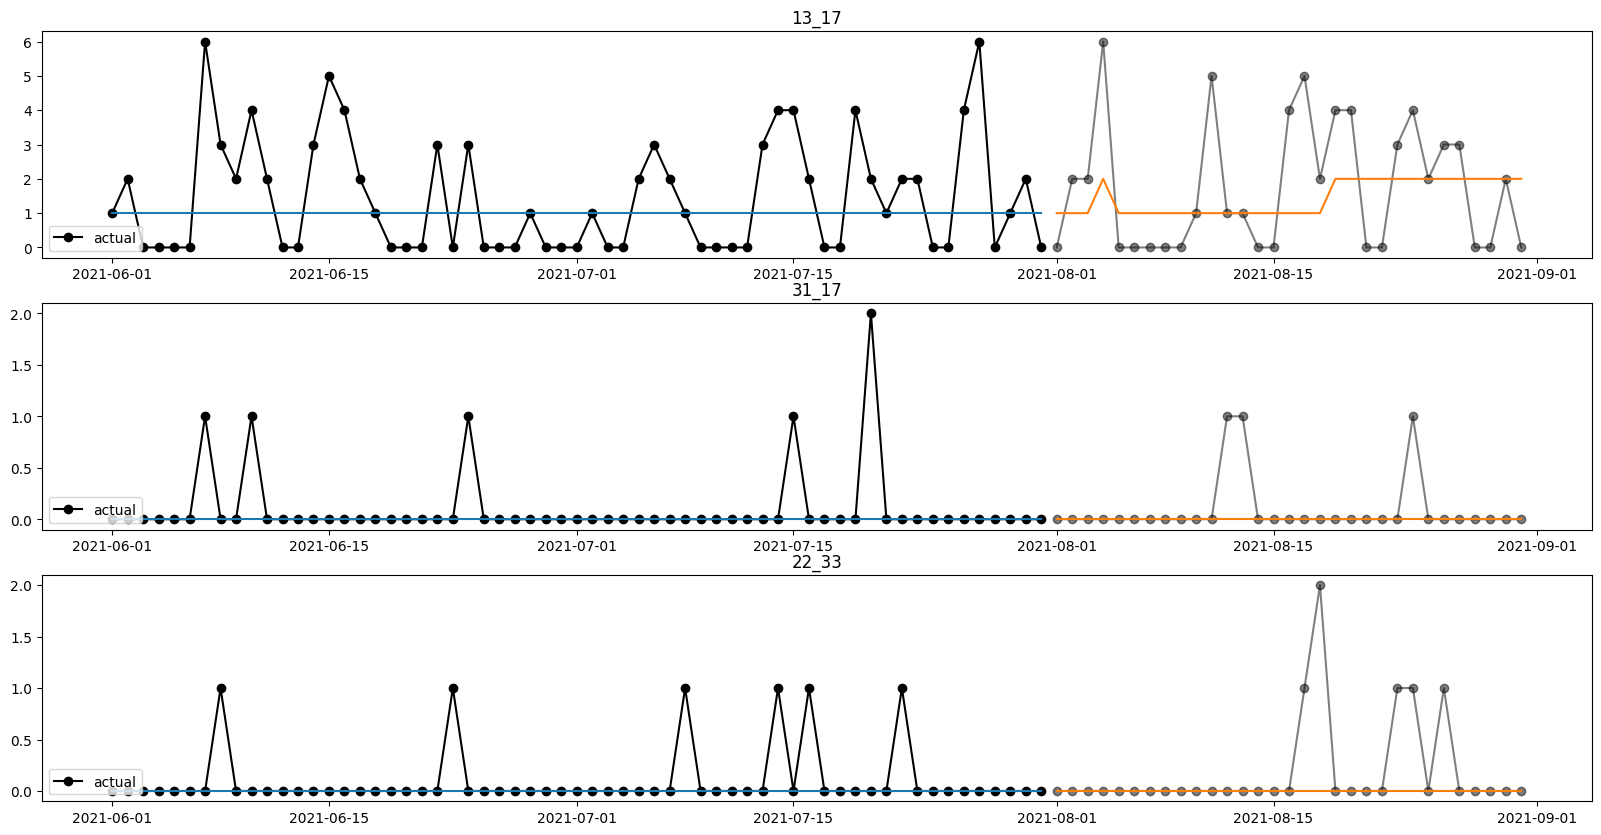

In [26]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][:61], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][61:], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][:61], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'SES_pred'][:61], )
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][61:], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'SES_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Metodo de Holt

In [27]:
series_ods_SEH = series_ods.copy()

results_SEH = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_SEH.loc[series_ods_SEH["OD"] == par ].reset_index(drop=True)
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            SEH_base = Holt(X['Volume_OD'].values, damped_trend= True,initialization_method="estimated").fit()
            [temp.append(int(np.around(SEH_base.fittedvalues[i],0))) for i in range(len(SEH_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            SEH_base = Holt(X['Volume_OD'].values, damped_trend= True, initialization_method="estimated").fit(  smoothing_level = SEH_base.model.params["smoothing_level"],
                                                                                                                smoothing_trend = SEH_base.model.params["smoothing_trend"]  )
            temp.append(int(np.around(SEH_base.fittedvalues[-1],0)))

    ################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_SEH.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['SEH_RMSE'] = errors_RMSE
errors_324['SEH_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_SEH = pd.concat([series_ods_SEH,pd.Series(reduce(lambda xs, ys: xs + ys, results_SEH), name = 'SEH_pred')], axis = 1, ignore_index = True)
series_ods_SEH.columns = ['OD', 'Data', 'Volume_OD', 'SEH_pred']

series_ods_SEH

,OD,Data,Volume_OD,SEH_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,27
29804,33_33,2021-08-28,0,27
29805,33_33,2021-08-29,0,5
29806,33_33,2021-08-30,25,1


In [28]:
errors_324

,OD,MA4_RMSE,MA4_MAE,SES_RMSE,SES_MAE,SEH_RMSE,SEH_MAE
0,1_1,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478
1,1_5,1.507229,1.141304,1.563858,1.206522,1.587998,1.239130
2,1_6,1.179536,0.869565,1.202353,0.945652,1.202353,0.945652
3,1_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1_9,0.989071,0.652174,1.058095,0.619565,1.042572,0.760870
...,...,...,...,...,...,...,...
319,33_23,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478
320,33_26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
321,33_31,0.714751,0.402174,0.793999,0.369565,0.820922,0.478261
322,33_32,0.820922,0.456522,0.989071,0.478261,1.063219,0.695652


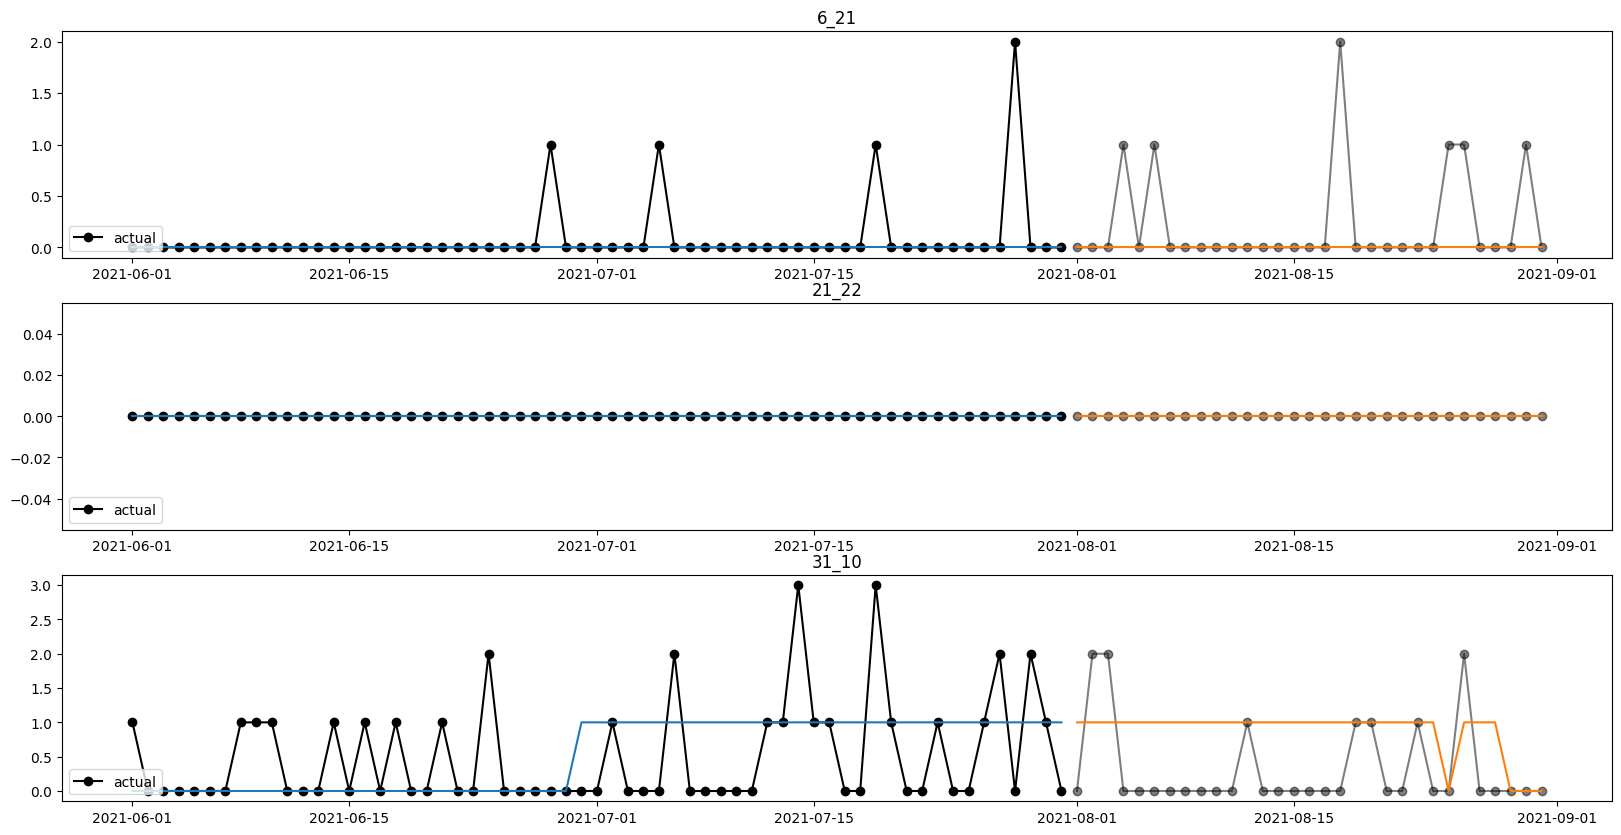

In [29]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][:61], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][61:], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][:61], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'SEH_pred'][:61], )
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][61:], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'SEH_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Metodo de Holt Winters

- O metodo de winter holts assume que todos os valores da series sao estritamente positivos, portanto nao negativos e diferentes de zero. Isso eh decorrente do uso da transformada de box-cox no metodo.
- A natureza dos dados em questao, devido a sua alta granularidade, eh pouco provavel ter boas previsoes para essas series temporais.
- Ainda assim, para fim de demonstracao do metodo em todos os casos, organizacoes de dados e com step-by-step, os valores zeros serao substituidos por valores aleatorios da ordem de 10e-5 para a execucao completa do modelo
- Dessa forma o codigo e logica da modelagem ainda podem ser utilizados em outro contexto e serie temporal

In [142]:
series_ods_WH = series_ods.copy()

results_WH = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_WH.loc[series_ods_WH["OD"] == par ].reset_index(drop=True)
    par_od.loc[par_od['Volume_OD'] == 0 ,'Volume_OD'] = [(random.random()*10e-5) for i in range(par_od.loc[par_od['Volume_OD'] == 0].shape[0])]
    par_od['Volume_OD'] = par_od['Volume_OD'].astype(float)
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            WH_base = ExponentialSmoothing( X['Volume_OD'].values,
                                            seasonal_periods=2,
                                            trend="add",
                                            seasonal="add",
                                            damped_trend=True,
                                            use_boxcox=True,
                                            initialization_method="estimated").fit()
            [temp.append(int(np.around(WH_base.fittedvalues[i],0))) for i in range(len(WH_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            WH_base = ExponentialSmoothing( X['Volume_OD'].values,
                                            seasonal_periods=2,
                                            trend="add",
                                            seasonal="add",
                                            damped_trend=True,
                                            use_boxcox=True,
                                            initialization_method="estimated").fit( smoothing_level = WH_base.model.params["smoothing_level"],
                                                                                    smoothing_trend = WH_base.model.params["smoothing_trend"],
                                                                                    optimized = True  )
            temp.append(int(np.around(WH_base.fittedvalues[-1],0)))

################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_WH.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['WH_RMSE'] = errors_RMSE
errors_324['WH_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_WH = pd.concat([series_ods_WH,pd.Series(reduce(lambda xs, ys: xs + ys, results_WH), name = 'WH_pred')], axis = 1, ignore_index = True)
series_ods_WH.columns = ['OD', 'Data', 'Volume_OD', 'WH_pred']

series_ods_WH

,OD,Data,Volume_OD,WH_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,45
29804,33_33,2021-08-28,0,15
29805,33_33,2021-08-29,0,0
29806,33_33,2021-08-30,25,0


In [143]:
errors_324

,OD,MA4_RMSE,MA4_MAE,SES_RMSE,SES_MAE,SEH_RMSE,SEH_MAE,WH_RMSE,WH_MAE
0,1_1,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478,0.208514,0.043522
1,1_5,1.507229,1.141304,1.563858,1.206522,1.587998,1.239130,2.040354,1.358720
2,1_6,1.179536,0.869565,1.202353,0.945652,1.202353,0.945652,1.584572,1.032631
3,1_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000056,0.000049
4,1_9,0.989071,0.652174,1.058095,0.619565,1.042572,0.760870,1.242368,0.695676
...,...,...,...,...,...,...,...,...,...
319,33_23,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478,0.208514,0.043531
320,33_26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058,0.000050
321,33_31,0.714751,0.402174,0.793999,0.369565,0.820922,0.478261,0.793999,0.369608
322,33_32,0.820922,0.456522,0.989071,0.478261,1.063219,0.695652,1.005420,0.489166


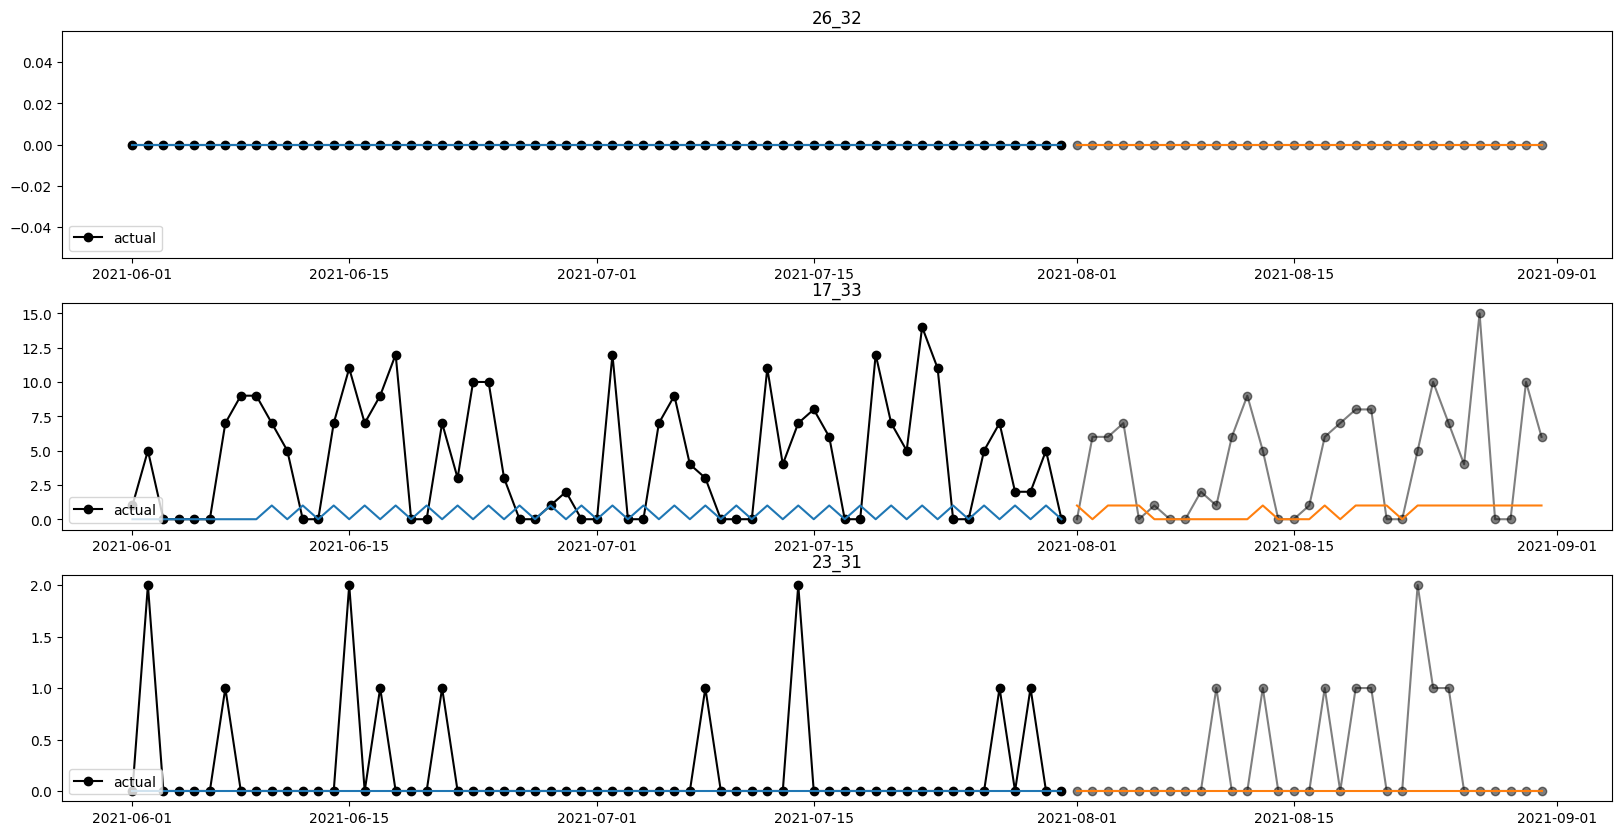

In [117]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32' 
# pra esse modelo apenas os interessantes sao '21_5', '17_33'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'Data'][:61], series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'Data'][61:], series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'Data'][:61], series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'WH_pred'][:61], )
    ax[aaa].plot(series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'Data'][61:], series_ods_WH.loc[series_ods_WH["OD"]==amostra[aaa],'WH_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## ARIMA


#### Modelagem

In [144]:
p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 2 #MediaMovel

series_ods_ARIMA = series_ods.copy()

results_ARIMA = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_ARIMA.loc[series_ods_ARIMA["OD"] == par ].reset_index(drop=True)
    par_od['Volume_OD'] = par_od['Volume_OD'].astype(float)
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]

        if i == 61:
            ARIMA_base = ARIMA(X['Volume_OD'],order=(p,d,q)).fit()
            [temp.append(int(np.around(ARIMA_base.fittedvalues[i],0)))for i in range(len(ARIMA_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            ARIMA_base = ARIMA(X['Volume_OD'],order=(p,d,q)).fit()
            temp.append(int(np.around(ARIMA_base.fittedvalues[i-1],0)))

################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_ARIMA.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['ARIMA_RMSE'] = errors_RMSE
errors_324['ARIMA_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_ARIMA = pd.concat([series_ods_ARIMA,pd.Series(reduce(lambda xs, ys: xs + ys, results_ARIMA), name = 'ARIMA_pred')], axis = 1, ignore_index = True)
series_ods_ARIMA.columns = ['OD', 'Data', 'Volume_OD', 'ARIMA_pred']

series_ods_ARIMA

################################################################################################################

,OD,Data,Volume_OD,ARIMA_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,20
29804,33_33,2021-08-28,0,18
29805,33_33,2021-08-29,0,4
29806,33_33,2021-08-30,25,10


In [145]:
errors_324

,OD,MA4_RMSE,MA4_MAE,SES_RMSE,SES_MAE,SEH_RMSE,SEH_MAE,WH_RMSE,WH_MAE,ARIMA_RMSE,ARIMA_MAE
0,1_1,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478,0.208514,0.043522,0.208514,0.043478
1,1_5,1.507229,1.141304,1.563858,1.206522,1.587998,1.239130,2.040354,1.358720,1.556892,1.184783
2,1_6,1.179536,0.869565,1.202353,0.945652,1.202353,0.945652,1.584572,1.032631,1.251086,0.956522
3,1_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000056,0.000049,0.000000,0.000000
4,1_9,0.989071,0.652174,1.058095,0.619565,1.042572,0.760870,1.242368,0.695676,1.047772,0.663043
...,...,...,...,...,...,...,...,...,...,...,...
319,33_23,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478,0.208514,0.043531,0.233126,0.054348
320,33_26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058,0.000050,0.000000,0.000000
321,33_31,0.714751,0.402174,0.793999,0.369565,0.820922,0.478261,0.793999,0.369608,0.853382,0.489130
322,33_32,0.820922,0.456522,0.989071,0.478261,1.063219,0.695652,1.005420,0.489166,0.966842,0.608696


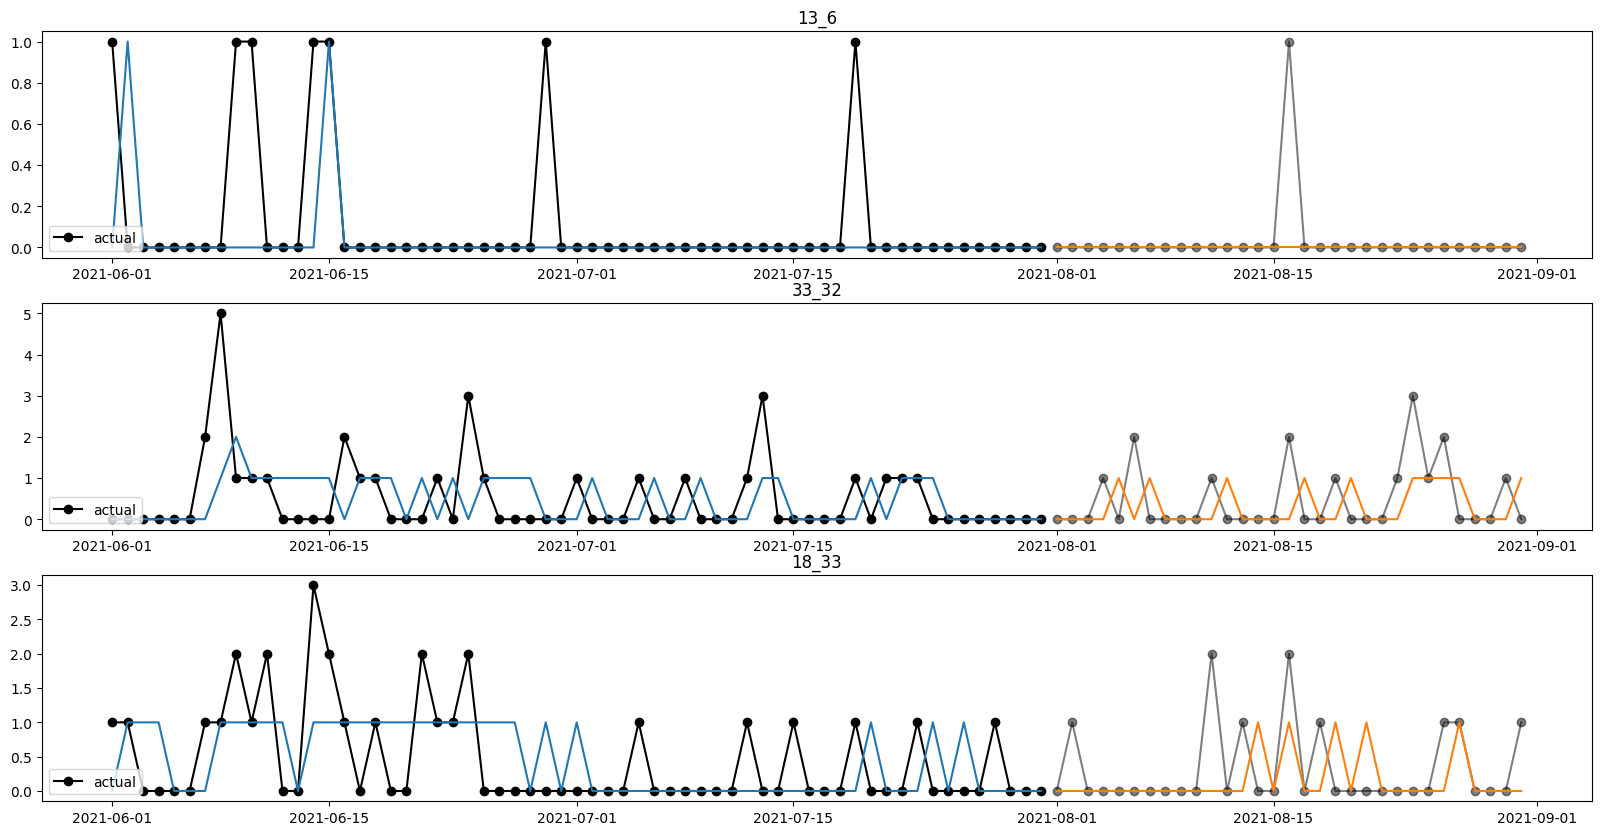

In [147]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32' 
# pra esse modelo apenas os interessantes sao '21_5', '17_33'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'Data'][:61], series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'Data'][61:], series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'Data'][:61], series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'ARIMA_pred'][:61], )
    ax[aaa].plot(series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'Data'][61:], series_ods_ARIMA.loc[series_ods_ARIMA["OD"]==amostra[aaa],'ARIMA_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Calculo dos erros médios

In [215]:
erros_melted = pd.DataFrame(errors_324.describe().transpose()['mean']).reset_index()
erros_melted.loc[erros_melted['index'].str.contains('MAE'),'error_type'] = 'MAE'
erros_melted.loc[erros_melted['index'].str.contains('RMSE'),'error_type'] = 'RMSE'

erros_melted.loc[erros_melted['index'].str.contains('MA4'),'index'] = 'MA4'
erros_melted.loc[erros_melted['index'].str.contains('SES'),'index'] = 'SES'
erros_melted.loc[erros_melted['index'].str.contains('SEH'),'index'] = 'SEH'
erros_melted.loc[erros_melted['index'].str.contains('WH'),'index'] = 'WH'
erros_melted.loc[erros_melted['index'].str.contains('ARIMA'),'index'] = 'ARIMA'


erros_melted.pivot(columns='index', index='error_type', values='mean')

index,ARIMA,MA4,SEH,SES,WH
error_type,,,,,
MAE,0.430958,0.394055,0.445552,0.451490,0.475719
RMSE,0.668602,0.624348,0.675511,0.678545,0.814926
